# Goals of this Training

* Use Python to combine powerful libraries
  - Numerical: Pandas, NumPy
  - Scikit-Learn
  - Image Manipulation
* Know what you are doing
* Appreciate the beauty of the language
* Jupyter Notebooks are also very cool


# Exercise
* Load spectral image from a matlab file (.mat) into a 3-dimensional matrix. (See `scipy.io.loadmat`)
* Use the K-Means algorithm to find clusters in the image. (See `sklearn.cluster.KMeans`)
* Do something with that information. E.g. create a picture where the spectral pixels are converted to a RGB image of the same (x,y) dimension.

# Links
* [XKCD color survey](https://blog.xkcd.com/2010/05/03/color-survey-results/)
* Basics
 - [Python Imaging Library](https://python-pillow.org/)
 - [NumPy](https://numpy.org/)
 - [SciPy](https://www.scipy.org/)
 - [Pandas](https://pandas.pydata.org/)
 - [Matplotlib](https://matplotlib.org/)
 - [Jupyter Notebook](https://jupyter.org/)
* Documentation and Tutorials
 - Python
   + [Corey Schafer's Youtube Channel](https://www.youtube.com/user/schafer5/)
   + [Python Documentation](https://docs.python.org/3/)
 - Numpy and all that
   + [Keith Galli's Youtube Channel](https://www.youtube.com/channel/UCq6XkhO5SZ66N04IcPbqNcw/featured)
     - [Numpy Arrays](https://www.youtube.com/watch?v=GB9ByFAIAH4). Watch out for "*boolean masking and advanced indexing*" 
  at around 50'.
   + [Numpy and SciPy offical Documentation](https://docs.scipy.org/doc/)
   + [Machine Learning, Sci-Kit Learn](https://www.youtube.com/watch?v=GB9ByFAIAH4)
* [Spyder vs. PyCharm](https://idlecoding.com/ide-comparison-spyder-vs-pycharm/). Spyder tries really hard to make global variables even more global, by retaining them in a context that it reuses between program invocations. The cited comparison is really comprehensive, but still nobody seems to have a problem with that misfeature.

# Walkthrough: Reduce Image to Eight Colors
A related but more obvious problem is: given an RGB image, reduce colors to, say, eight.

* Load PNG image into NumPy array
* Make sense of it
* Use K-Means to find eight clusters
* Reduce colors by assigning center's RGB to members
* Convert NumPy array back into PNG

In [53]:
IMGFILE = 'veggie.png'

## Load Image from File: PIL

### Rant
* PIL was the original Python Imaging Library
* For some reason a fork was created
* [Pillow](https://python-pillow.org/)
* Takes a while to learn to interpret Google search hits in this way
* Welcome to Open Source

In [54]:
import PIL.Image

img = PIL.Image.open(IMGFILE)

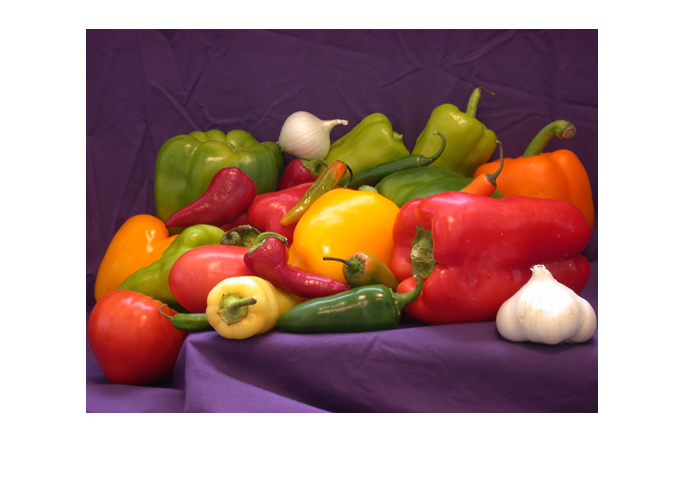

In [55]:
img

## Image as NumPy Array
This is easy: PIL is there to cooperate with numpy. The array shape, in this image's case, is 477x686 for the x and y image dimensions, and 4 high for the (r,g,b,alpha) part.

In [56]:
import numpy
imgarray = numpy.array(img)

In [57]:
imgarray.ndim

3

In [58]:
imgarray.shape

(477, 686, 4)

In [59]:
imgarray.dtype

dtype('uint8')

In [60]:
imgarray

array([[[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       ...,

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255

In [61]:
imgarray[200,300] # arbitrary pixel somewhere in the middle

array([172, 104,  25, 255], dtype=uint8)

## Preparation before Clustering
* Cut off Alpha plane
* Clustering input: only "3d" RGB values

In [62]:
rgb = imgarray[:,:,0:3]
alpha = imgarray[:,:,3]

In [63]:
rgb.shape

(477, 686, 3)

In [64]:
# remember for later
nrows, ncols, _ = rgb.shape

In [65]:
alpha.shape

(477, 686)

While we have compatible x,y sizes, we are missing one dimension in the alpha matrix. We need this to stack alpha on top of the reduced image once we have it.

In [66]:
alpha = alpha.reshape(alpha.shape + (1,))

This could have been done easier by slicing a *range* of size 1 instead ...

In [67]:
alpha = imgarray[:,:,3:]

In [68]:
alpha.shape

(477, 686, 1)

## Excursion: matplotlib
Completely irrelevant: see where the points are in the RGB colorspace. Could spend more time on it though; for example, the points could be colored.

Text(0.5, 0, 'B')

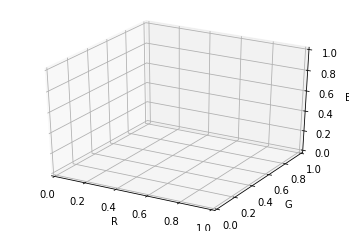

In [69]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')

In [70]:
rs = []
gs = []
bs = []
for x, y in numpy.ndindex(nrows,ncols):
    r,g,b = rgb[x,y]
    rs.append(r)
    gs.append(g)
    bs.append(b)

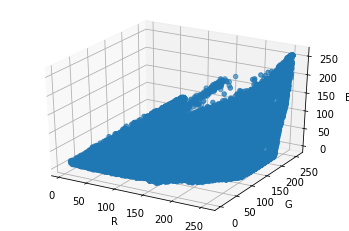

In [71]:
ax.scatter(rs,gs,bs)
fig

## Now Comes the Clustering

* [scikit-learn](https://scikit-learn.org/)
* Huge data science toolbox
* [K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html): "Given a set of data points, find N clusters and their centers"

We have a two-dimensional array of (r,g,b) values. KMeans is not interested in (x,y), so linearize the input.
*Note* that reshaping an array is a zero-copy operation - it only gives a different view onto the same memory.

In [72]:
rgb_linear = rgb.reshape(nrows*ncols, 3)

### Let KMeans find eight clusters ...

In [73]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=8)
km.fit(rgb_linear)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

### Use the result: output-properties
* labels_: cluster membership for each point in the input sequence
* cluster_centers_: eight RGB values

In [74]:
km.labels_

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [75]:
len(km.labels_)

327222

In [76]:
nrows*ncols

327222

In [77]:
km.cluster_centers_

array([[ 67.20281219,  37.50641824,  61.38429828],
       [254.94373611, 254.75283084, 254.52811317],
       [226.50936884,  73.56048652,  41.93819855],
       [122.87441738,  81.89438044, 132.85929118],
       [121.7147305 , 114.48089442,  25.60931624],
       [225.51222162, 182.84206953, 136.05852797],
       [157.17577775,  24.37724576,  28.02338582],
       [241.37446066, 159.30799596,  14.39557514]])

### Clusters be their Centers
Assign each point the RGB values of the center it is attached to

In [78]:
for idx, label in enumerate(km.labels_):
    rgb_linear[idx] = km.cluster_centers_[label]

### Post Processing: Restore Alpha, Back into RGBA
*Note*: while we have manipulated the RGB cube via `rgb_linear` (a two-dimensional view of it), we use the original three-dimensional `rgb` array.

In [79]:
imgarray = numpy.concatenate((rgb, alpha), axis=2)

In [80]:
reduced_img = PIL.Image.fromarray(imgarray, 'RGBA')

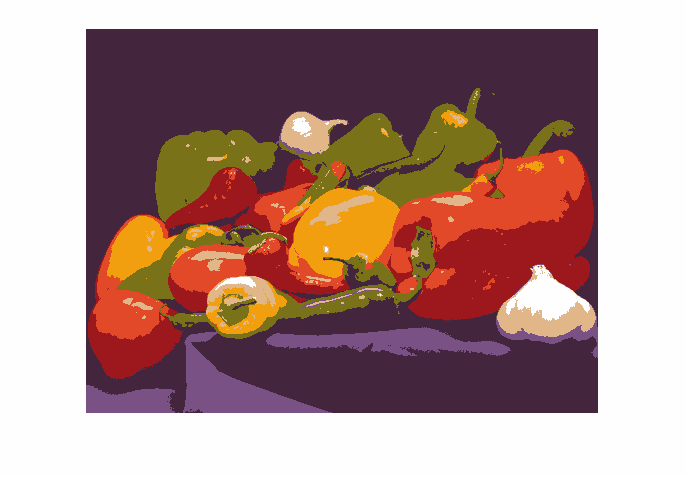

In [81]:
reduced_img